In [1]:
import sys
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import matplotlib.cm as cm

sys.path.append("/home/isidro/Documents/github/SimpleMC/")
from simplemc.plots.plot_Quintom_variables import *
from simplemc.models.QuintomCosmology import QuintomCosmology
from simplemc.models.LCDMCosmology import LCDMCosmology
from simplemc.cosmo.Parameter import Parameter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.utils import to_categorical
# from tensorboard.plugins.hparams import api as hp

# from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import time 

%matplotlib inline

Initalizing nu density look up table... Done


/home/isidro/Documents/github/SimpleMC/simplemc/likelihoods/JLA_SN.py:24: UserWarning: Please import GetDist library if you want to make getdist posterior plots.
  warnings.warn("Please import GetDist library if you want to make getdist posterior plots.")
2022-12-09 21:47:54.125021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 21:47:54.211230: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-09 21:47:54.211247: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on yo

In [2]:
om_ = Parameter("Om", 0.3038, 0.05, (0.1, 0.5), "\Omega_m")
obh2_ = Parameter("Obh2", 0.02234, 0.001, (0.02, 0.025), "\Omega_{b}h^2")
h_ = Parameter("h", 0.6821, 0.05, (0.4, 0.9), "h")
mquin_ = Parameter("mquin", 1.7, 0.2, (0, 4.0), "m_{\phi}")
mphan_ = Parameter("mphan", 0.8, 0.2, (0, 3.0), "m_{\psi}")
iniphi_ = Parameter("iniphi", 0.5, 0.1, (0, 1.5), "\phi_0")
coupling_ = Parameter("beta",  1.0, 0.5, (-10, 10), "\\beta")

In [3]:
minim, maxim = (0.1, 2.5)

T = QuintomCosmology(vary_mquin=True)

ww = []
# dd = []
X = []
Y = []
mquin_data = np.arange(0, 4, 0.5)

for i, val in enumerate(mquin_data):
#     if fname == 'Quintessence':
    mquin_.setValue(val)
    T.updateParams([mquin_])

    T.call_functions()
    zl = np.arange(0.0, 3.5, 0.01)
    wlist = []
    for z in zl:
        X.append([z, val])
        eos = T.w_de(1./(1+z))
        wlist.append(eos)
        Y.append(eos)
    ww.append(wlist)       
#     print(ww[i])

X = np.array(X)
Y = np.array(Y)

In [4]:
np.shape(ww), np.shape(mquin_data), np.shape(zl), np.shape(X), np.shape(Y)

((8, 350), (8,), (350,), (2800, 2), (2800,))

(-1.05, 1.1)

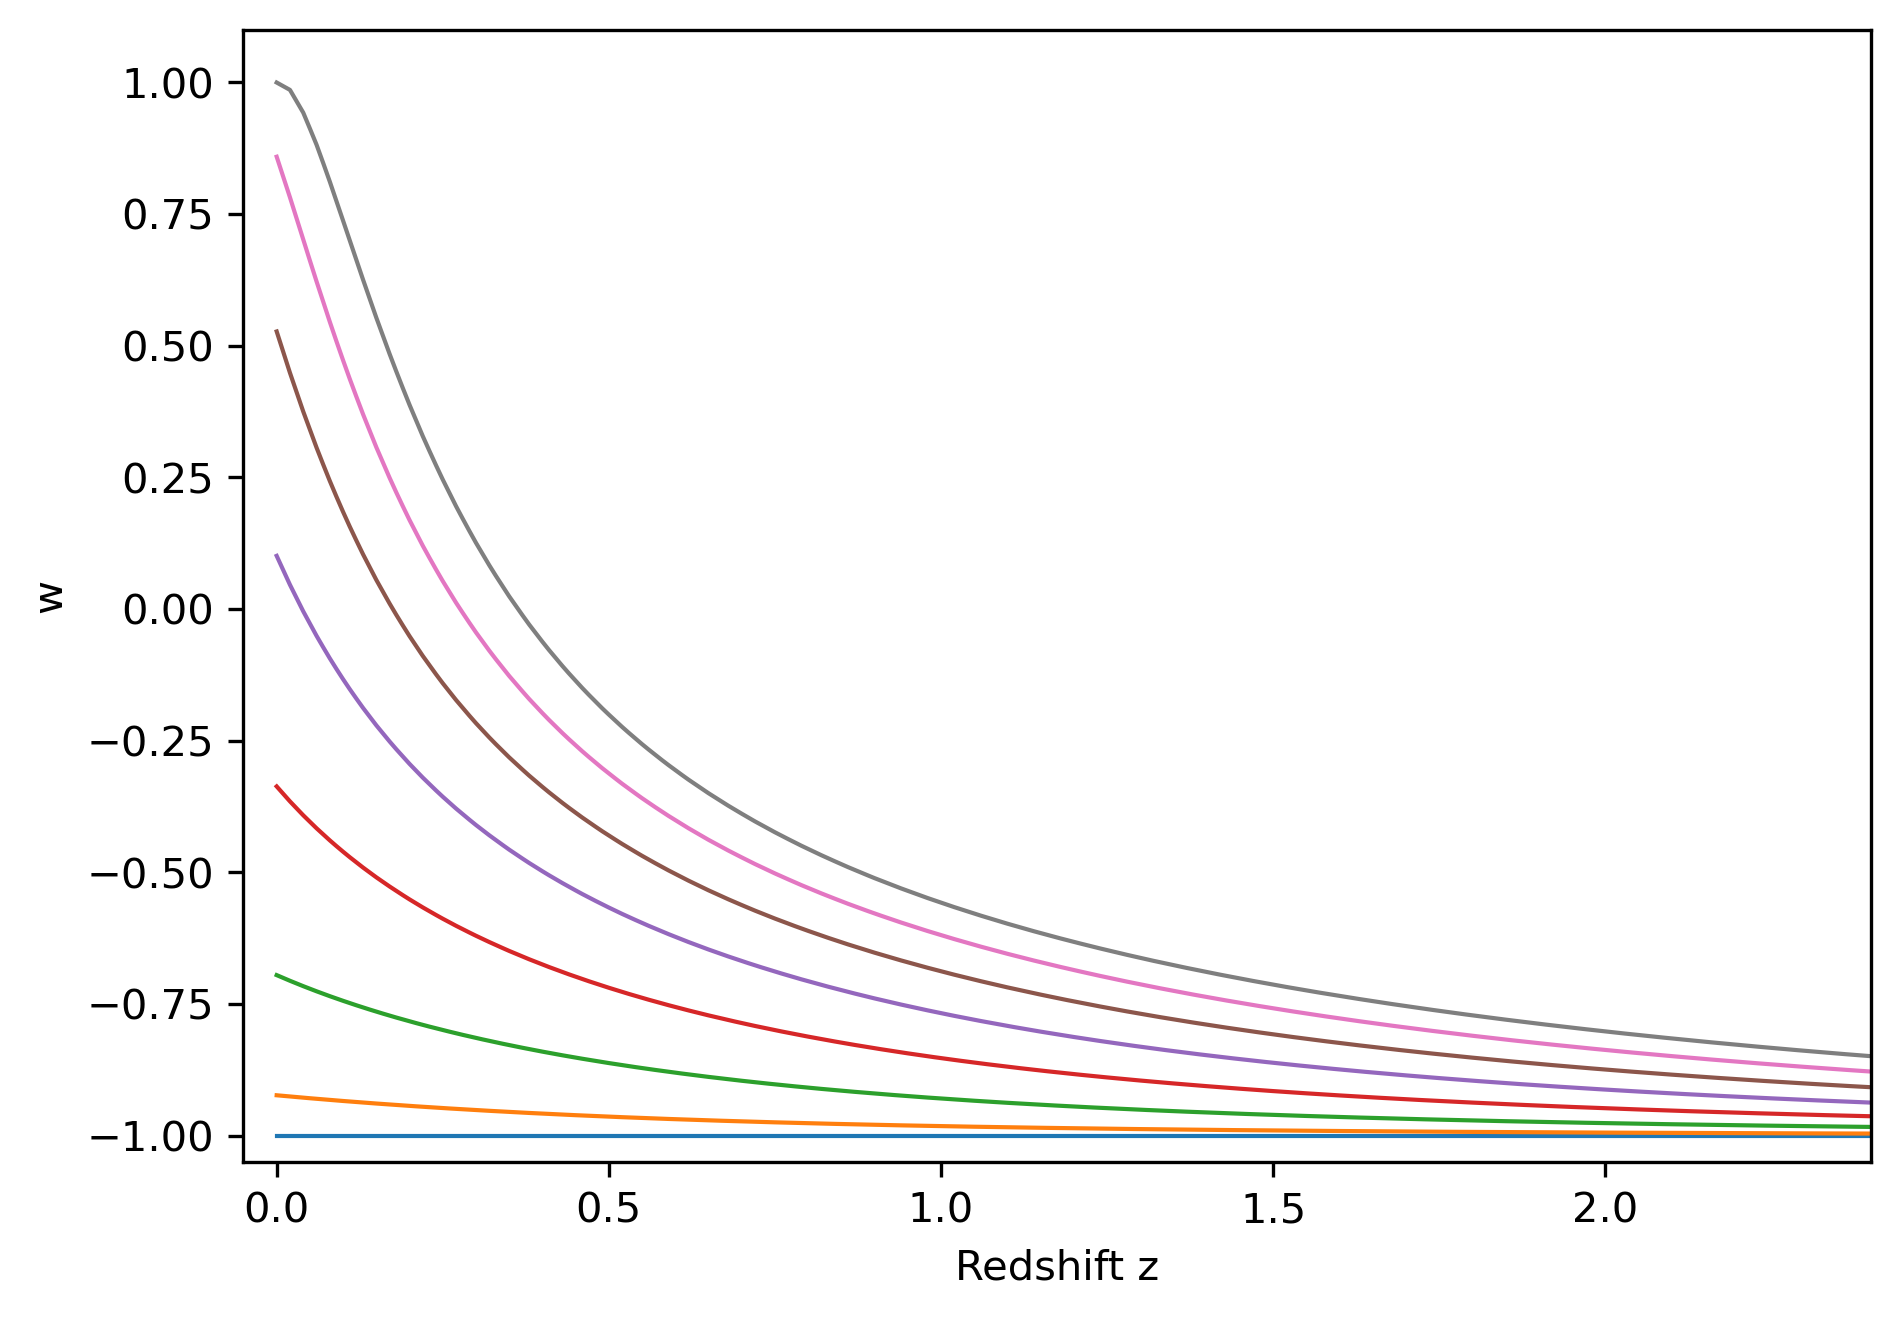

In [5]:
fig = plt.figure(figsize=(7,5), dpi=300)

for line in ww:
    plt.plot(zl, line, alpha=1, lw=1)

plt.xlabel("Redshift z")
plt.ylabel("w")
plt.xlim(-0.05, 2.4)
plt.ylim(-1.05, 1.1)
# plt.hlines(-1, xmin=0, xmax=3.05, colors='red',  linestyles='dashed', label='$w=-1$', lw=3, alpha=1)

In [6]:
epochs=100
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=500,
                                   restore_best_weights=True, verbose=False)
                                   ]

In [7]:
def train_test_model(hparams, X_train, Y_train, X_test, Y_test):    
    
    # Train LSTM model and predict on validation set
    model = tf.keras.Sequential()
    model.add(Dense(int(X_train.shape[1])))
    
    for i in range(hparams['HP_LAYERS']):        
        model.add(Dense(hparams['HP_NUM_UNITS'], activation='relu'))
    model.add(Dense(1, activation='linear'))
     
    optimizer = tf.keras.optimizers.Adam(learning_rate=hparams['HP_LEARNING'], beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    model.compile(
            optimizer=optimizer,
            loss='mse', 
            metrics=['mean_squared_error'])
    
    # Run with 1 epoch to speed things up for demo purposes

    train = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_test, Y_test),
              callbacks=callbacks, batch_size=hparams['HP_BATCHSIZE'], shuffle=False, verbose=True)

    _, loss = model.evaluate(X_test, Y_test)
    
    return model, loss, train.history

In [8]:
#Separamos los datos en validación y entrenamiento
ntrain = int(0.8 * len(Y))
indx = [ntrain]
shuffle = np.random.permutation(len(X))
X = X[shuffle]
Y = Y[shuffle]
X_train, X_val = np.split(X, indx)
Y_train, Y_val = np.split(Y, indx)
# nval = int(0.5*(len(X_test)))
# indx_val = [nval]
# X_val, X_test = np.split(X_test, indx_val)
# Y_val, Y_test = np.split(Y_test, indx_val)

In [9]:
np.shape(X_train), np.shape(Y_train), np.shape(X_val), np.shape(Y_val)

((2240, 2), (2240,), (560, 2), (560,))

# With hyperparameters founded by the grid.

In [10]:
# 4	200	0.001	16
hparams_grid1 = {'HP_LAYERS': 4, 'HP_NUM_UNITS': 200, 'HP_BATCHSIZE': 16, 'HP_LEARNING':0.001}
model1, loss1, history1 = train_test_model(hparams_grid1, X_train, Y_train, X_val, Y_val)

Epoch 1/100


2022-12-09 21:47:55.963227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 21:47:55.963394: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-09 21:47:55.963448: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-09 21:47:55.963493: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-09 21:47:55.963538: W tensorflow/c

140/140 [==============================] - 1s 2ms/step - loss: 0.1092 - mean_squared_error: 0.1092 - val_loss: 0.0297 - val_mean_squared_error: 0.0297
Epoch 2/100
140/140 [==============================] - 0s 1ms/step - loss: 0.0257 - mean_squared_error: 0.0257 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 3/100
140/140 [==============================] - 0s 1ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 4/100
140/140 [==============================] - 0s 1ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 6.9683e-04 - val_mean_squared_error: 6.9683e-04
Epoch 5/100
140/140 [==============================] - 0s 1ms/step - loss: 9.2225e-04 - mean_squared_error: 9.2225e-04 - val_loss: 4.1568e-04 - val_mean_squared_error: 4.1568e-04
Epoch 6/100
140/140 [==============================] - 0s 1ms/step - loss: 6.3272e-04 - mean_squared_error: 6.3272e-04 - val_loss: 3.7651e-04 - val_mean_squared_error: 3.765

Epoch 47/100
140/140 [==============================] - 0s 1ms/step - loss: 1.4856e-04 - mean_squared_error: 1.4856e-04 - val_loss: 2.0515e-04 - val_mean_squared_error: 2.0515e-04
Epoch 48/100
140/140 [==============================] - 0s 1ms/step - loss: 7.6174e-05 - mean_squared_error: 7.6174e-05 - val_loss: 4.2451e-05 - val_mean_squared_error: 4.2451e-05
Epoch 49/100
140/140 [==============================] - 0s 1ms/step - loss: 3.6355e-05 - mean_squared_error: 3.6355e-05 - val_loss: 1.1257e-05 - val_mean_squared_error: 1.1257e-05
Epoch 50/100
140/140 [==============================] - 0s 1ms/step - loss: 3.8598e-05 - mean_squared_error: 3.8598e-05 - val_loss: 1.3219e-04 - val_mean_squared_error: 1.3219e-04
Epoch 51/100
140/140 [==============================] - 0s 1ms/step - loss: 5.2984e-04 - mean_squared_error: 5.2984e-04 - val_loss: 4.4045e-04 - val_mean_squared_error: 4.4045e-04
Epoch 52/100
140/140 [==============================] - 0s 1ms/step - loss: 1.7790e-04 - mean_square

140/140 [==============================] - 0s 1ms/step - loss: 3.7997e-05 - mean_squared_error: 3.7997e-05 - val_loss: 1.9196e-05 - val_mean_squared_error: 1.9196e-05
Epoch 93/100
140/140 [==============================] - 0s 1ms/step - loss: 2.1756e-05 - mean_squared_error: 2.1756e-05 - val_loss: 5.8123e-05 - val_mean_squared_error: 5.8123e-05
Epoch 94/100
140/140 [==============================] - 0s 1ms/step - loss: 2.1898e-05 - mean_squared_error: 2.1898e-05 - val_loss: 9.5217e-05 - val_mean_squared_error: 9.5217e-05
Epoch 95/100
140/140 [==============================] - 0s 1ms/step - loss: 2.5526e-05 - mean_squared_error: 2.5526e-05 - val_loss: 1.4730e-04 - val_mean_squared_error: 1.4730e-04
Epoch 96/100
140/140 [==============================] - 0s 1ms/step - loss: 3.6753e-05 - mean_squared_error: 3.6753e-05 - val_loss: 9.2572e-05 - val_mean_squared_error: 9.2572e-05
Epoch 97/100
140/140 [==============================] - 0s 1ms/step - loss: 4.1706e-05 - mean_squared_error: 4.17

(-0.001, 0.025)

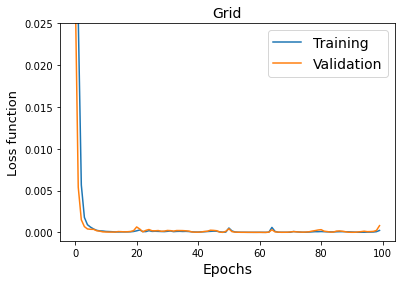

In [11]:
plt.plot(history1['loss'], label='Training')
plt.plot(history1['val_loss'], label='Validation')
plt.ylabel('Loss function', fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.title("Grid", fontsize=14)
plt.ylim(-0.001, 0.025)
# plt.savefig("loss_grid_ecs.png")

In [12]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 6         
                                                                 
 dense_1 (Dense)             (None, 200)               600       
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 dense_3 (Dense)             (None, 200)               40200     
                                                                 
 dense_4 (Dense)             (None, 200)               40200     
                                                                 
 dense_5 (Dense)             (None, 1)                 201       
                                                                 
Total params: 121,407
Trainable params: 121,407
Non-trai

# Genetic

In [13]:
# 4 	200 	0.0010 	8 
hparams_grid2 = {'HP_LAYERS': 4, 'HP_NUM_UNITS': 200, 'HP_BATCHSIZE': 8, 'HP_LEARNING':0.001}
model2, loss2, history2 = train_test_model(hparams_grid2, X_train, Y_train, X_val, Y_val)

Epoch 1/100
280/280 [==============================] - 1s 2ms/step - loss: 0.0485 - mean_squared_error: 0.0485 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2/100
280/280 [==============================] - 0s 1ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 3/100
280/280 [==============================] - 0s 1ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 4/100
280/280 [==============================] - 0s 1ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 4.2867e-04 - val_mean_squared_error: 4.2867e-04
Epoch 5/100
280/280 [==============================] - 0s 1ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 2.8971e-04 - val_mean_squared_error: 2.8971e-04
Epoch 6/100
280/280 [==============================] - 0s 1ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 2.6918e-04 - val_mean_squared_error: 2.6918e-0

280/280 [==============================] - 0s 1ms/step - loss: 4.0047e-05 - mean_squared_error: 4.0047e-05 - val_loss: 3.3784e-05 - val_mean_squared_error: 3.3784e-05
Epoch 48/100
280/280 [==============================] - 0s 1ms/step - loss: 5.2714e-05 - mean_squared_error: 5.2714e-05 - val_loss: 1.0521e-05 - val_mean_squared_error: 1.0521e-05
Epoch 49/100
280/280 [==============================] - 0s 1ms/step - loss: 1.0042e-04 - mean_squared_error: 1.0042e-04 - val_loss: 1.8121e-04 - val_mean_squared_error: 1.8121e-04
Epoch 50/100
280/280 [==============================] - 0s 1ms/step - loss: 1.2728e-04 - mean_squared_error: 1.2728e-04 - val_loss: 1.0803e-04 - val_mean_squared_error: 1.0803e-04
Epoch 51/100
280/280 [==============================] - 0s 1ms/step - loss: 7.0293e-05 - mean_squared_error: 7.0293e-05 - val_loss: 2.0798e-05 - val_mean_squared_error: 2.0798e-05
Epoch 52/100
280/280 [==============================] - 0s 1ms/step - loss: 4.0554e-05 - mean_squared_error: 4.05

280/280 [==============================] - 0s 1ms/step - loss: 4.4295e-05 - mean_squared_error: 4.4295e-05 - val_loss: 2.8831e-04 - val_mean_squared_error: 2.8831e-04
Epoch 93/100
280/280 [==============================] - 0s 1ms/step - loss: 1.8472e-04 - mean_squared_error: 1.8472e-04 - val_loss: 1.4297e-04 - val_mean_squared_error: 1.4297e-04
Epoch 94/100
280/280 [==============================] - 0s 1ms/step - loss: 1.0223e-04 - mean_squared_error: 1.0223e-04 - val_loss: 7.2096e-06 - val_mean_squared_error: 7.2096e-06
Epoch 95/100
280/280 [==============================] - 0s 1ms/step - loss: 1.3232e-05 - mean_squared_error: 1.3232e-05 - val_loss: 2.8906e-06 - val_mean_squared_error: 2.8906e-06
Epoch 96/100
280/280 [==============================] - 0s 1ms/step - loss: 1.0063e-05 - mean_squared_error: 1.0063e-05 - val_loss: 3.9399e-06 - val_mean_squared_error: 3.9399e-06
Epoch 97/100
280/280 [==============================] - 0s 1ms/step - loss: 5.1627e-06 - mean_squared_error: 5.16

In [14]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 2)                 6         
                                                                 
 dense_7 (Dense)             (None, 200)               600       
                                                                 
 dense_8 (Dense)             (None, 200)               40200     
                                                                 
 dense_9 (Dense)             (None, 200)               40200     
                                                                 
 dense_10 (Dense)            (None, 200)               40200     
                                                                 
 dense_11 (Dense)            (None, 1)                 201       
                                                                 
Total params: 121,407
Trainable params: 121,407
Non-tr

In [15]:
loss1, loss2

(0.0008112937794066966, 1.0953438504657242e-05)

In [16]:
# mphi_test = np.unique(X_test[:, 1])
# ztest = np.unique(X_test[:, 0])
mphi_test = np.arange(0, 4, 0.5)
ztest = np.arange(0.0, 3.5, 0.05)

testset = []
for mphi in mphi_test:
    for z in ztest:
        testset.append([z, mphi])

testset = np.array(testset)
np.shape(testset)

(560, 2)

In [17]:
testset

array([[0.  , 0.  ],
       [0.05, 0.  ],
       [0.1 , 0.  ],
       ...,
       [3.35, 3.5 ],
       [3.4 , 3.5 ],
       [3.45, 3.5 ]])

In [18]:
def eos_fn(params):
#     T = QuintomCosmology(vary_mquin=True)
    z, mphi_val = params
    mquin_.setValue(mphi_val)
    T.updateParams([mquin_])
    T.call_functions()
    
    eos = T.w_de(1./(1+z))
    return eos
    

In [19]:
T = QuintomCosmology(vary_mquin=True)
ww_diff = list(map(eos_fn, testset))    

In [20]:
ww_net1 = model1.predict(testset)
ww_net2 = model2.predict(testset)

18/18 [==============================] - 0s 743us/step


In [21]:
np.shape(ww_net1), np.shape(ww_diff), np.shape(testset[:,0])

((560, 1), (560,), (560,))

In [22]:
testset

array([[0.  , 0.  ],
       [0.05, 0.  ],
       [0.1 , 0.  ],
       ...,
       [3.35, 3.5 ],
       [3.4 , 3.5 ],
       [3.45, 3.5 ]])

In [23]:

lines = []

# testset = []
for i, mphi in enumerate(testset[:,1]):
    if i > 0:
        if mphi != testset[i-1, 1]:
            aux=[]
            for j, z in enumerate(ztest):
                aux.append([ww_diff[i+j], ww_net1[i+j], ww_net2[i+j]])
            lines.append(aux)

lines = np.array(lines, dtype=object)
# lines_net1 = np.array(lines_net1)
# lines_net2 = np.array(lines_net2)


In [24]:
lines_diff = lines[:,:,0]
lines_net1 = lines[:,:,1]
lines_net2 = lines[:,:,2]

np.shape(lines), np.shape(lines_diff), np.shape(lines_net1), np.shape(lines_net2)

((7, 70, 3), (7, 70), (7, 70), (7, 70))

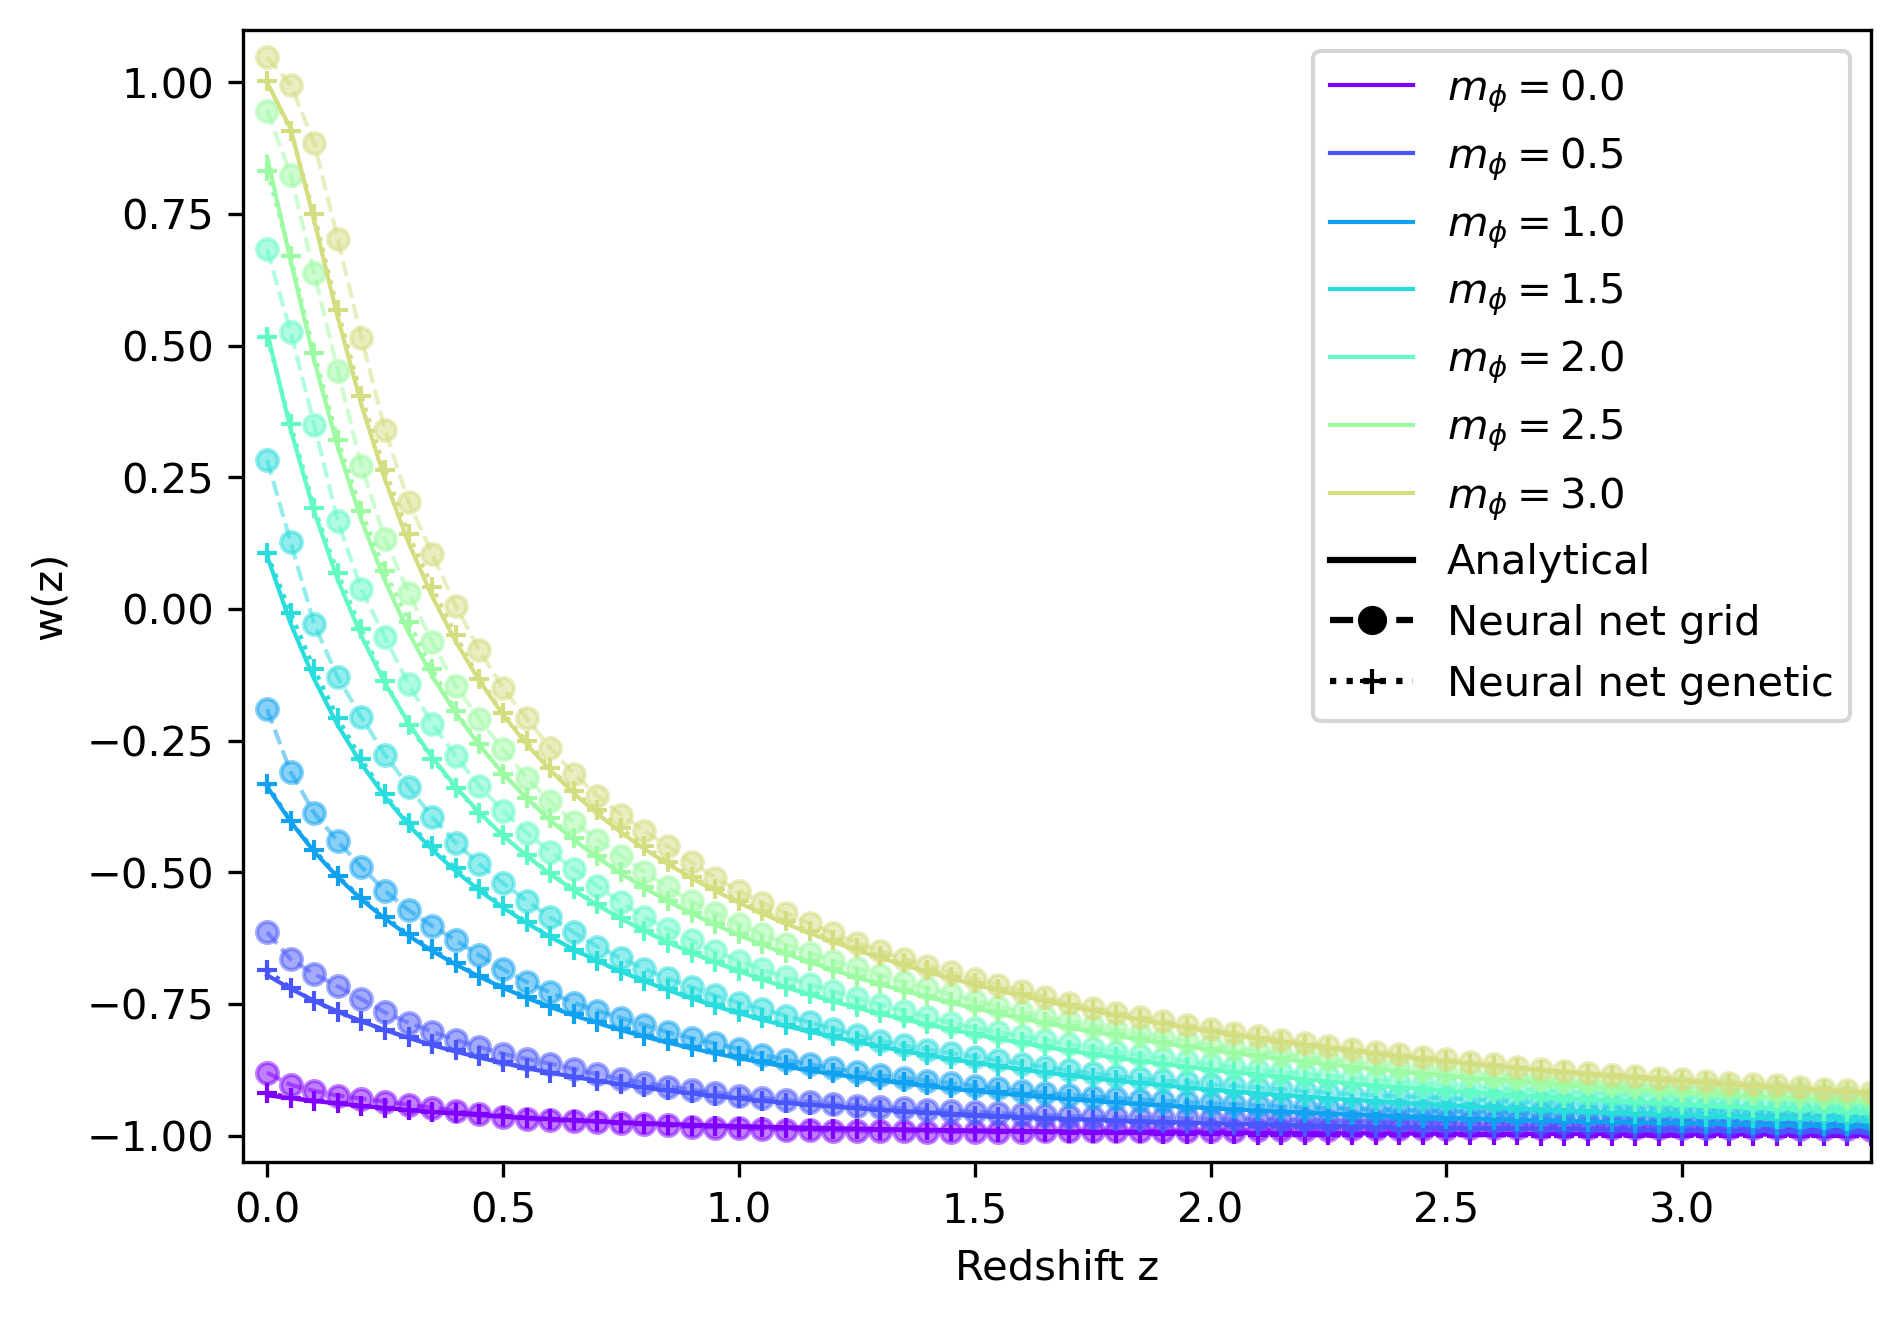

In [25]:
x = np.arange(len(ww_net1))
ys = [i+x+(i*x)**2 for i in range(10)]

colors = cm.rainbow(np.linspace(0, 1, len(ys)))

fig = plt.figure(figsize=(7,5), dpi=300)

for i, line in enumerate(lines_diff):
#     if i%10 == 0:
    plt.plot(ztest, lines_diff[i], alpha=1, lw=1, label = "$m_\phi={}$".format(mphi_test[i]), c=colors[i])
    plt.plot(ztest, lines_net1[i], alpha=0.5, lw=1, linestyle='dashed', marker='o', c=colors[i], markersize=5)
    plt.plot(ztest, lines_net2[i], alpha=1, lw=1, linestyle=':', marker='+', c=colors[i], markersize=5)

plt.plot(-2,-2, label = "Analytical", c='black' )
plt.plot(-2,-2, label = "Neural net grid", linestyle='dashed', marker='o', c='black')
plt.plot(-2,-2, label = "Neural net genetic", linestyle=':', marker='+', c='black')
# plt.plot(np.unique(X_test[:,0]), line, alpha=1, lw=1, linestyle='dashed', c=colors[i])
plt.xlabel("Redshift z")
plt.ylabel("w(z)")
plt.xlim(-0.05, 3.4)
plt.ylim(-1.05, 1.1)
# plt.text(1, 0.8, "- Analytical --Neural Net")

plt.legend()
plt.savefig("eos_quintess.png")
# plt.hlines(-1, xmin=0, xmax=3.05, colors='red',  linestyles='dashed', label='$w=-1$', lw=3, alpha=1)

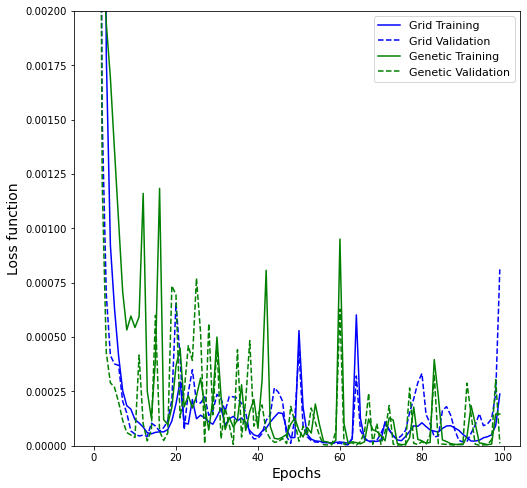

In [26]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.plot(history1['loss'], label='Grid Training', color='blue')
plt.plot(history1['val_loss'], label='Grid Validation', color='blue', linestyle='dashed')
plt.plot(history2['loss'], label='Genetic Training', color='green')
plt.plot(history2['val_loss'], label='Genetic Validation', color='green', linestyle='dashed')
plt.ylim(0, 0.002)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.ylabel('Loss function', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.legend(loc='upper right', fontsize=11)
# plt.title("Genetic algorithm", fontsize=14)
plt.savefig("eos_loss.png")

In [27]:
model1.save("models/netEoSgrid.h5")
model2.save("models/netEoSgenetic.h5")

In [28]:
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error

In [29]:
y_pred_grid = model1.predict(X_val)
y_pred_genetic = model2.predict(X_val)

18/18 [==============================] - 0s 730us/step


In [30]:
r1 = r2_score(Y_val, y_pred_grid)
r2 = r2_score(Y_val, y_pred_genetic)
r1, r2

(0.9872684017481825, 0.9998281081719913)

In [31]:
mae1 = mean_absolute_error(Y_val, y_pred_grid)
mae2 = mean_absolute_error(Y_val, y_pred_genetic)
mae1, mae2

(0.01740238753063546, 0.0020032843287614674)